In [273]:
import pandas as pd
import os

In [274]:
#NY Times Covid Github repo
nytimesgit = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
county_covid = pd.read_csv(nytimesgit, header=0)

In [275]:
county_covid['date'] = pd.to_datetime(county_covid['date']).dt.date

In [276]:
cases_by_county = county_covid.set_index(["state",'county', "date"]).sort_index().\
    groupby(level=1).tail(1)['cases'].sort_values(ascending=False)
cases_by_county

state         county         date      
New York      New York City  2020-03-31    43139
              Westchester    2020-03-31     9967
              Nassau         2020-03-31     8544
              Suffolk        2020-03-31     6713
Illinois      Cook           2020-03-31     4496
                                           ...  
Georgia       Screven        2020-03-31        1
North Dakota  Sioux          2020-03-31        1
Georgia       Stewart        2020-03-31        1
North Dakota  Walsh          2020-03-31        1
Wyoming       Washakie       2020-03-31        1
Name: cases, Length: 1367, dtype: int64

In [277]:
county_covid = county_covid.set_index(["state", "county", "date"]).sort_index()

In [278]:
pd.options.display.max_rows=1000
pd.options.display.max_columns=200
cum = cases_by_county.cumsum()/cases_by_county.sum()
pd.concat([cases_by_county, cum], names=['cases', "cum_cases"], axis=1).head(30).to_csv("Cases_by_county_3_27_20.csv")

In [279]:
cum

state         county         date      
New York      New York City  2020-03-31    0.303871
              Westchester    2020-03-31    0.374078
              Nassau         2020-03-31    0.434262
              Suffolk        2020-03-31    0.481548
Illinois      Cook           2020-03-31    0.513218
                                             ...   
Georgia       Screven        2020-03-31    0.999972
North Dakota  Sioux          2020-03-31    0.999979
Georgia       Stewart        2020-03-31    0.999986
North Dakota  Walsh          2020-03-31    0.999993
Wyoming       Washakie       2020-03-31    1.000000
Name: cases, Length: 1367, dtype: float64

In [280]:
def parse_fips(s):
    if s == pd.np.nan:
        return None
    c_int = s%1000
    c = format(c_int, "03.0f")
    s_int = (s-c_int)/1000
    st = format(s_int, "02.0f")
    return st+c

In [281]:
county_covid['fips'] = county_covid.fips.apply(parse_fips)

In [282]:
download = "c:/users/lee/downloads"
county_pop =pd.read_csv(os.path.join(download, "co-est2019-alldata.csv"), encoding = "ISO-8859-1", header=0)

In [283]:
county_pop.STATE = county_pop.STATE.apply(lambda x: format(x, "02.0f"))

In [284]:
county_pop.COUNTY = county_pop.COUNTY.apply(lambda x: format(x, "03.0f"))

In [285]:
county_pop['fips']=county_pop['STATE']+county_pop['COUNTY']

In [286]:
pop_19 = county_pop.set_index("fips")[["CTYNAME", "STNAME", "POPESTIMATE2019"]]
pop_19

,CTYNAME,STNAME,POPESTIMATE2019
fips,,,
01000,Alabama,Alabama,4903185
01001,Autauga County,Alabama,55869
01003,Baldwin County,Alabama,223234
01005,Barbour County,Alabama,24686
01007,Bibb County,Alabama,22394
...,...,...,...
56037,Sweetwater County,Wyoming,42343
56039,Teton County,Wyoming,23464
56041,Uinta County,Wyoming,20226


In [287]:
joined = county_covid.reset_index().set_index(["fips", 'date'])[['cases', 'deaths']].join(pop_19)
county_covid_perK= (joined[['cases', 'deaths']]*1e3).div(joined.POPESTIMATE2019, axis=0)
county_covid_perK
county_covid_perK["case_pct_change"]= county_covid_perK['cases'].pct_change()
rolling = county_covid_perK.groupby(level=0).rolling(3).mean()["case_pct_change"].reset_index(0, drop=True)
rolling.name = "3d_rolling_case_chg"
rolling
#county_covid_perK['case_pct_change_2']= county_covid_perK['case_pct_change'].pct_change()

fips    date      
01001   2020-03-24         NaN
        2020-03-25         NaN
        2020-03-26         NaN
        2020-03-27    1.166667
        2020-03-28    0.166667
                        ...   
nannan  2020-03-27    0.000000
        2020-03-28    0.000000
        2020-03-29    0.000000
        2020-03-30    0.000000
        2020-03-31    0.000000
Name: 3d_rolling_case_chg, Length: 23967, dtype: float64

In [288]:
rolling_chg = rolling.groupby(level=0).pct_change()
rolling_chg.name  ="3d_rolling_case_chg_2"

In [291]:
county_covid_perK = county_covid_perK.join(rolling).join(rolling_chg).join(pop_19)
county_covid_perK

cases  deaths  case_pct_change  3d_rolling_case_chg  \
fips   date                                                                 
01001  2020-03-24  0.017899     0.0              NaN                  NaN   
       2020-03-25  0.071596     0.0              3.0                  NaN   
       2020-03-26  0.107394     0.0              0.5                  NaN   
       2020-03-27  0.107394     0.0              0.0             1.166667   
       2020-03-28  0.107394     0.0              0.0             0.166667   
...                     ...     ...              ...                  ...   
nannan 2020-03-31       NaN     NaN              0.0             0.000000   
       2020-03-31       NaN     NaN              0.0             0.000000   
       2020-03-31       NaN     NaN              0.0             0.000000   
       2020-03-31       NaN     NaN              0.0             0.000000   
       2020-03-31       NaN     NaN              0.0             0.000000   

                   3d_rolling_case_chg_2         CTYNAME   STNAME  \
fips   date                                                         
01001  2020-03-24                    NaN  Autauga County  Alabama   
       2020-03-25                    NaN  Autauga County  Alabama   
       2020-03-26                    NaN  Autauga County  Alabama   
       2020-03-27                    NaN  Autauga County  Alabama   
       2020-03-28              -0.857143  Autauga County  Alabama   
...                                  ...             ...      ...   
nannan 2020-03-31                    NaN             NaN      NaN   
       2020-03-31                    NaN             NaN      NaN   
       2020-03-31                    NaN             NaN      NaN   
       2020-03-31                    NaN             NaN      NaN   
       2020-03-31                    NaN             NaN      NaN   

                   POPESTIMATE2019  
fips   date                         
01001  2020-03-24          55869.0  
       2020-03-25          55869.0  
       2020-03-26          55869.0  
       2020-03-27          55869.0  
       2020-03-28          55869.0  
...                            ...  
nannan 2020-03-31              NaN  
       2020-03-31              NaN  
       2020-03-31              NaN  
       2020-03-31              NaN  
       2020-03-31              NaN  

[211233 rows x 8 columns]

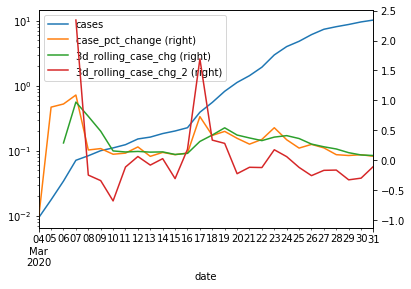

In [305]:
cols = ['cases', 'case_pct_change', '3d_rolling_case_chg','3d_rolling_case_chg_2']
data = county_covid_perK.loc[('36119',)][cols]
ax = data['cases'].plot(legend=True, logy=True)
data[cols[1:]].plot(secondary_y=True, ax=ax)

In [308]:
county_covid_perK.groupby(level=0).last().sort_values(by='cases', ascending=False).head(100)

,cases,deaths,case_pct_change,3d_rolling_case_chg,3d_rolling_case_chg_2,CTYNAME,STNAME,POPESTIMATE2019
fips,,,,,,,,
36119,10.301745,0.025840,0.068733,8.174659e-02,-9.916345e-02,Westchester County,New York,967506.0
36087,8.787896,0.024556,0.140183,1.473270e-01,-2.671536e-01,Rockland County,New York,325789.0
16013,8.340211,0.086877,0.297297,1.976752e-01,3.259569e-01,Blaine County,Idaho,23021.0
36059,6.296594,0.046429,0.163399,1.556248e-01,-5.191340e-02,Nassau County,New York,1356924.0
13095,5.298104,0.295602,0.676259,3.014812e-01,1.727243e+00,Dougherty County,Georgia,87956.0
22071,4.700828,0.258879,0.239189,1.251824e-01,5.281074e-01,Orleans Parish,Louisiana,390144.0
08051,4.695911,0.057267,0.025000,1.682625e-02,-7.564906e-01,Gunnison County,Colorado,17462.0
13273,4.688782,0.234439,1.000000,6.666667e-01,2.000000e-01,Terrell County,Georgia,8531.0
36103,4.546252,0.035893,0.159213,1.753269e-01,-1.073273e-01,Suffolk County,New York,1476601.0
